In [7]:

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import torch
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForImageTextRetrieval

processor = BlipProcessor.from_pretrained("Salesforce/blip-itm-large-coco")
model = BlipForImageTextRetrieval.from_pretrained("Salesforce/blip-itm-large-coco")


In [9]:
from peft import get_peft_model, LoraConfig, TaskType
lora_config = LoraConfig(
    r=64,
    lora_alpha=64,
    lora_dropout=0.01,
    target_modules=["qkv", "query", "key", "value", "dense", "projection", "fc1", "fc2", "text_proj", "visual_proj", "position_embeddings"],
)
model = get_peft_model(model, lora_config)  

In [10]:
model.print_trainable_parameters()

trainable params: 41,041,920 || all params: 487,170,562 || trainable%: 8.4245


In [16]:
processor(images=Image.new('RGB', (94, 34)), text="A cat", return_tensors="pt").pixel_values.shape

torch.Size([1, 3, 512, 512])

In [ ]:

model = model.cuda()
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
train_ds = load_dataset("zai-org/VisionRewardDB-Image", split='train[:40000]')
test_ds = load_dataset("zai-org/VisionRewardDB-Image", split='train[40000:]')

import io, math, random
import numpy as np
from PIL import Image, ImageFilter, ImageEnhance
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pandas as pd

df = pd.read_csv("rules.csv")

import pandas as pd
import re

df.columns = df.columns.str.strip()
df['Dimension'] = df['Dimension'].ffill()

df['dim_key'] = df['Dimension'].apply(lambda x: re.search(r'\((.*?)\)', x).group(1) if re.search(r'\((.*?)\)', x) else x)

guide = {
    dim_key: {
        int(row['Score']): row['Option'] + ": " +str(row['Description']).strip()
        for _, row in group.iterrows()
    }
    for dim_key, group in df.groupby('dim_key')
}

dims = {k: v for k, v in guide.items() if k not in ["unsafe type", "hands", "face", "body", "safety", "lighting aesthetic", "symmetry"]}.keys()
dims = list(dims)
dim_min = {i:min(guide[i].keys()) for i in guide.keys()}

# %%

import json
with open("prompts.json", "r") as f:
    prompt_dict = json.load(f)



In [2]:

def format_data(sample):
    images = []
    dims_selected = []
    # print(len(sample["image"]), len(sample["annotation"]))
    for image in range(len(sample['image'])):
        images.append(sample['image'][image])
        try:
            if random.random()>0.5:
                # sample a dim with score>=0 
                dims_selected.append(random.choice(list([i for i in dims if sample['annotation'][image][i]>=0])))
            else:
                # sample a dim with score<0
                dims_selected.append(random.choice(list([i for i in dims if sample['annotation'][image][i]<0])))
        except IndexError:
            dims_selected.append(random.choice(dims))
            

    prompts = [prompt_dict[dim] for i, dim in enumerate(dims_selected)]
    images = list(sample['image'])
    n_images = len(images)
    n_prompts = len(prompts) 
    inputs = processor(images=images, text=prompts, return_tensors="pt", padding=True)
    answers = [1 if i[dim]<0 else (0.5 if i[dim]==0 else 0) for i, dim in zip(sample["annotation"], dims_selected)]
    labels = torch.tensor(answers)
    inputs['labels'] = labels
    inputs['dim'] = [dims.index(dim) for dim in dims_selected]
    inputs['n_images'] = [n_images] * len(inputs['input_ids'])
    return {
        'pixel_values': inputs['pixel_values'],
        'input_ids': inputs['input_ids'],
        'attention_mask': inputs['attention_mask'],
        'labels': inputs['labels'], 
        'dims': dims_selected,
        'n_images': inputs['n_images'],
        # "annotation": [i[dim] for i, dim in zip(sample["annotation"], dims_selected)],
    } 



# %%
train_ds = train_ds.with_transform(format_data)
test_ds = test_ds.with_transform(format_data)

In [3]:
# train_ds[0:7]["labels"]

In [4]:

import wandb

import torch
from transformers import PreTrainedModel, PretrainedConfig

class Rater(PreTrainedModel):
    def __init__(self, backbone):
      super().__init__(PretrainedConfig())
      self.backbone = backbone
      self.head = torch.nn.Linear(768, 1)

    def forward(self, pixel_values, input_ids, attention_mask, n_images, labels=None):
      n_images = n_images[0]
      outputs = self.backbone(pixel_values=pixel_values, input_ids=input_ids, attention_mask=attention_mask)
      itm_scores = self.head(outputs.question_embeds[:,0,:]).squeeze(-1)

      if labels is not None:
        assert itm_scores.shape == labels.shape, f"{itm_scores.shape} {labels.shape}"
        assert itm_scores.shape[0] == n_images
        bce_loss = torch.nn.functional.binary_cross_entropy_with_logits(itm_scores, labels)
        mae_loss = torch.nn.functional.l1_loss(torch.sigmoid(itm_scores), labels)
        loss = bce_loss + mae_loss

        try: 
          wandb.log({"bce_loss": bce_loss, "acc": ((itm_scores>0) == (labels>0.5)).float().mean(), "mae_loss": mae_loss})
        except:
          pass
        outputs['loss'] = loss

      return outputs

my_rater = Rater(model)




In [5]:
# my_rater = my_rater.cpu()
# with torch.no_grad():
#     my_rater(**train_ds[0:2]) 

In [ ]:

from transformers import TrainingArguments
import os
training_args = TrainingArguments(
    output_dir="BLIP-Reward-Long",
    learning_rate=3e-4,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=1,
    num_train_epochs=20,
    weight_decay=0.001,
    eval_strategy="steps",
    save_strategy="steps",
    eval_steps=500,
    save_steps=500,
    logging_steps=1,
    load_best_model_at_end=True,
    push_to_hub=True,
    max_grad_norm=1.0,
    remove_unused_columns=False,
    dataloader_num_workers=min(os.cpu_count(), 16),
    fp16=True,
    warmup_ratio=0.01,
    lr_scheduler_type="cosine",
    # lr_scheduler_kwargs={"num_decay_steps": 500},
    report_to="wandb"
)


from peft import get_peft_model, LoraConfig, TaskType
lora_config = LoraConfig(
    r=32,
    lora_alpha=32,
    lora_dropout=0.01,
    target_modules=["qkv", "query", "key", "value", "dense", "projection"],
    modules_to_save=["head"] 
)
my_rater = get_peft_model(my_rater, lora_config)  
my_rater = my_rater.to("cuda")
my_rater.print_trainable_parameters()
from transformers import Trainer 

trainer = Trainer(
    model=my_rater,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    processing_class=processor,
)

# %%
trainer.train() 


trainable params: 12,585,219 || all params: 458,714,630 || trainable%: 2.7436


/home/wg25r/miniconda/envs/neg/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/home/wg25r/miniconda/envs/neg/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 0}.
wandb: Currently logged in as: wguo6358 (3dsmile) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss


In [1]:
from datasets import load_dataset
dataset = load_dataset("weathon/aas_benchmark", split="train")

In [7]:
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [6]:
all_prompts = " ".join(list(dataset['prompt_original']))
all_distorted_prompts = " ".join(list(dataset['prompt_distorted']))

/tmp/ipykernel_288959/3558334823.py:19: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Image.fromarray(np.array(wordcloud))


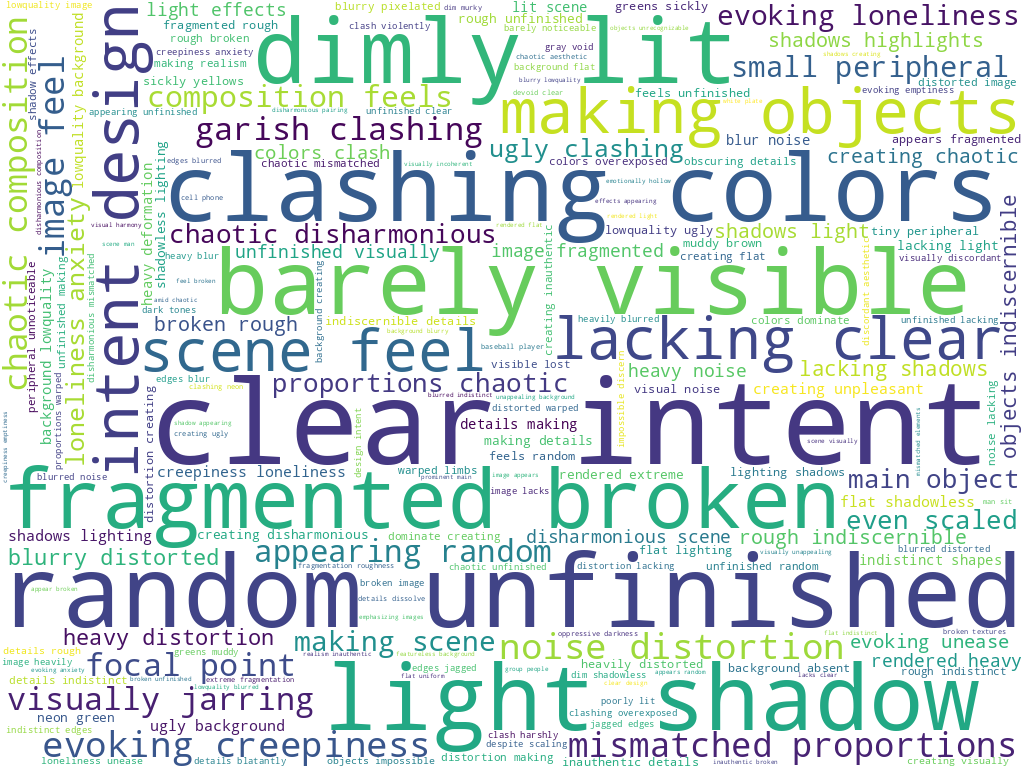

In [23]:
import re
from wordcloud import STOPWORDS

text = all_distorted_prompts

text = re.sub(r'[^A-Za-z\s]', '', text)

text = text.lower()

stopwords = set(STOPWORDS)
text = ' '.join(word for word in text.split() if word not in stopwords)

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

wordcloud = WordCloud(width=1024, height=768, background_color='white').generate(text)
Image.fromarray(np.array(wordcloud))